In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import sklearn.model_selection

# Titanic Survival 

## Goal: 
Using Kaggle dataset on titanic passengers - predict who will and will not survive the incident.
Kaggle provides a (labeled) training set and an (unlabelled) testing set.  

## Peeking at the Data:

Let's take a quick peek at the training data

In [20]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Non self-explanatory columns are described here:
 * PassengerID - Metadata label of the passenger
 * Survived - 1 Survived, 0 Didn't
 * Pclass - Passenger class.  1st, 2nd, 3rd
 * SibSp - Number of Siblings and Spouses 
 * ParCh - Number of Parents and Siblings on board
 * Fare - Fare paid by the passenger
 * Cabin - Cabin number
 * Embarked - C = Cherbourg, Q = Queenstown, S = Southampton


Clean up the data a bit so it's easier to manipulate:

In [28]:
clean_data = train_data
clean_data["Sex"] = train_data["Sex"].replace({"male":0, "female":1})
clean_data["Embarked"] = train_data["Embarked"].replace({"C":0, "Q":1, "S":2, np.NaN:3})
clean_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2


Glance at the statistics of the passengers at large:

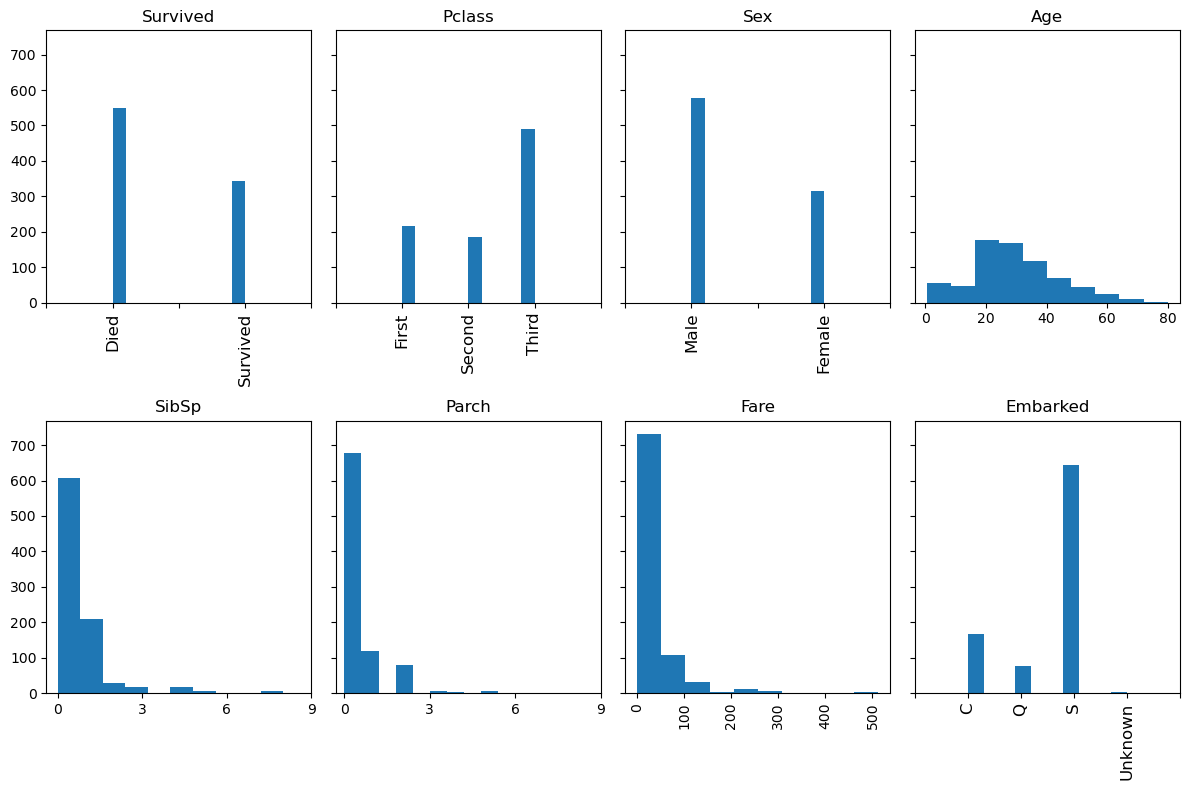

In [52]:
ax = clean_data.hist(
    column=["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"],
    figsize=(12, 8),
    layout=(2, 4),
    grid=False,
    sharey=True,
    sharex=False
)
ax[0][0].set_xticks(ax[0][0].get_xticks())
ax[0][0].set_xticklabels(["", "Died", "", "Survived", ""], rotation='vertical', fontsize=12)

ax[0][1].set_xticks(ax[0][1].get_xticks())
ax[0][1].set_xticklabels(["","First", "Second", "Third", ""], rotation='vertical', fontsize=12)

ax[0][2].set_xticks(ax[0][2].get_xticks())
ax[0][2].set_xticklabels(["","Male", "", "Female", ""], rotation='vertical', fontsize=12)

ax[0][3].set_xticks(np.arange(0, 100, 20))
ax[1][0].set_xticks(np.arange(0, 12, 3))
ax[1][1].set_xticks(np.arange(0, 12, 3))
ax[1][2].set_xticks(np.arange(0, 600, 100))
ax[1][2].set_xticklabels(np.arange(0, 600, 100), rotation='vertical')
ax[1][3].set_xticks(ax[1][3].get_xticks())
ax[1][3].set_xticklabels(["", "C", "Q", "S", "Unknown", ""], rotation='vertical', fontsize=12)


plt.tight_layout()
plt.show()

Nothing too surprising looking at individual variables. 

* More deaths and survivals
* More men than women on board
* A few families - but mostly traveling solo or in pairs.

## Looking at Individual Predictors of Survival

Let's get an intuition for which individual variable will be decent predictors of survival:

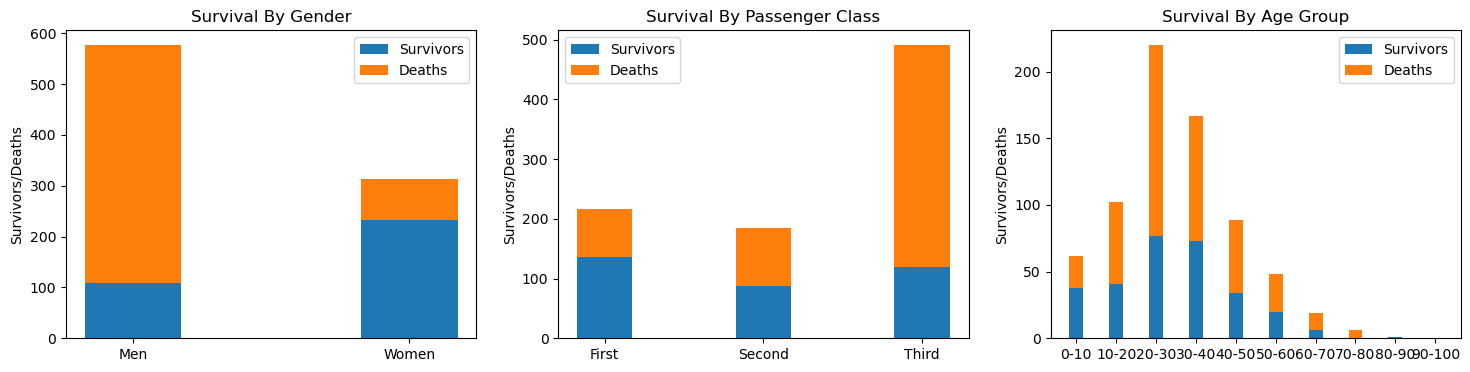

In [53]:
fig,axs = plt.subplots(1,3, figsize=(18, 4))

# Survival By Gender Code
labels = ["Men", "Women"]
survivors_by_gender = [
    len(clean_data[(clean_data["Survived"]==1) & (clean_data["Sex"] == 0)]),   # Male Survivor
    len(clean_data[(clean_data["Survived"]==1) & (clean_data["Sex"] == 1)])    # Female Survivors
]
deaths_by_gender = [
    len(clean_data[(clean_data["Survived"]==0) & (clean_data["Sex"] == 0)]),   # Male Deaths
    len(clean_data[(clean_data["Survived"]==0) & (clean_data["Sex"] == 1)])    # Female Deaths
]

width = 0.35       # the width of the bars: can also be len(x) sequence


axs[0].bar(labels, survivors_by_gender, width, label='Survivors')
axs[0].bar(labels, deaths_by_gender, width, bottom=survivors_by_gender,
       label='Deaths')

axs[0].set_ylabel('Survivors/Deaths')
axs[0].set_title('Survival By Gender')
axs[0].legend()

# Survival by Class Code
labels = ["First", "Second", "Third"]
survivors_by_class = [
    len(clean_data[(clean_data["Survived"]==1) & (clean_data["Pclass"] == 1)]),   # First Class Survivor
    len(clean_data[(clean_data["Survived"]==1) & (clean_data["Pclass"] == 2)]),   # Second Class Survivor
    len(clean_data[(clean_data["Survived"]==1) & (clean_data["Pclass"] == 3)])    # Third Class Survivors
]
deaths_by_class = [
    len(clean_data[(clean_data["Survived"]==0) & (clean_data["Pclass"] == 1)]),   # First Class Deaths
    len(clean_data[(clean_data["Survived"]==0) & (clean_data["Pclass"] == 2)]),   # Second Class Deaths
    len(clean_data[(clean_data["Survived"]==0) & (clean_data["Pclass"] == 3)])    # Third Class Deaths
]

width = 0.35       # the width of the bars: can also be len(x) sequence

axs[1].bar(labels, survivors_by_class, width, label='Survivors')
axs[1].bar(labels, deaths_by_class, width, bottom=survivors_by_class,
       label='Deaths')

axs[1].set_ylabel('Survivors/Deaths')
axs[1].set_title('Survival By Passenger Class')
axs[1].legend()


# Survival by Age Group
age_groups = np.arange(0, 100, 10)
labels = [
    f"{i}-{i+10}"
    for i in age_groups
]

survivors_by_age_group = [
    len(clean_data[(clean_data["Survived"]==1) & (clean_data["Age"] >= start) & (clean_data["Age"] < start+10)])
    for start in age_groups
]
deaths_by_age_group = [
    len(clean_data[(clean_data["Survived"]==0) & (clean_data["Age"] >= start) & (clean_data["Age"] < start+10)])
    for start in age_groups
]


width = 0.35       # the width of the bars: can also be len(x) sequence

axs[2].bar(labels, survivors_by_age_group, width, label='Survivors')
axs[2].bar(labels, deaths_by_age_group, width, bottom=survivors_by_age_group,
       label='Deaths')

axs[2].set_ylabel('Survivors/Deaths')
axs[2].set_title('Survival By Age Group')
axs[2].legend()

plt.show()

Again - no major surprises at this small slice of the data.  Gender is a great predictor of survival, and class and age are both useful as well.  


# Organizing our Data for the Network

So now we need to decide how to process the data.

#### Numerical Variables
 * Age
 * Sibsp (Siblings and Spouses on board)
 * Parch (Parents and Children on board)
 * Fare
 
#### Categorical Variables
 * Passenger Class (First, Second, Third)
 * Sex (Male or Female)
 * Port of Embarkation

#### Remarks
* There's an argument to interpret cabin class as a Numerical category.  I opted to treat it as categorical on the reasoning that there's just 3 classes - so the one-hot categorization is pretty cheap - and the relationship between passenger and social class is also being captured by the real-valued fare.
* Ticket Number and Cabin information will not be used in the first pass of this model.  It's not immediately clear what useful information is available here
* All Numerical variables will be unit-normalized and scaled
* All Categorical variables will be one hot encoded


## Building Data Pipeline

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categories=[
    [1, 2, 3],
    [0,1],
    [0, 1, 2, 3]
]

def make_transformer():
    
    numeric_pipeline = Pipeline([
        ("scale", StandardScaler()),
        ("impute", SimpleImputer(strategy='mean'))
    ])
    
    col_trans = ColumnTransformer(transformers = [
        ("numeric_var", numeric_pipeline, ["Age", "SibSp", "Parch", "Fare"]),
        ("categorical_var", OneHotEncoder(categories=categories), ["Pclass", "Sex", "Embarked"]),
        ],
        remainder="drop"
    )
    return col_trans


## Establishing Baselines

We'll look at a few non-network approaches to classifying the problem.
* Baseline Guess
* Decision Tree
* Random Forest
* Nearest Neighbors


### Baseline Guess

If we examine 0 variables- how well can we predict outcomes?

In [159]:
# What fraction survived?
s_rate = round((clean_data["Survived"] == 1).sum()/clean_data.shape[0] * 100, 2)
print(f"{s_rate}% of the training set survived")

38.38% of the training set survived


So the baseline hypothesis that **every passenger dies** will give us a roughly 60% accuracy.  

*What if we examine 1 variable?*

We saw earlier that gender, class, and age were decent predictors of survivability. 

How well would we do with a simple gender-based rule based on gender?

**Hypothesis:** All women Survive, all men die.  

In [177]:
# Testing Hypothesis that all women survive, all men die
# Count all women who survive
w_s = clean_data[(clean_data["Survived"] == 1) & (clean_data["Sex"] == 1)].shape[0]

# Men who died
m_d = clean_data[(clean_data["Survived"] == 0) & (clean_data["Sex"] == 0)].shape[0]

# Accuracy:
acc = (w_s + m_d)/len(clean_data)
print(f"Hypothesis has {round(acc*100,2)}% accuracy on the training data")

Hypothesis has 78.68% accuracy on the training data


So the very simple hypothesis that men die and women survive has **78.68%** accuracy on the training data.  Note that we aren't being very scientific here by building our hypothesis on the same training data we are using to evaluate the hypothesis.  But this hypothesis is so simple (ie not overfitted or p-hacked) that it will likely extend to new data without issue.  

So 78.68% will serve as a back-of-the-evelope baseline for our classifiers!

Let's build some classifiers and see how they fare

### Decision Tree Classifier

Decision Tree Classifier Extends the logic we just used above, extending it to multiple variables to build a 'tree' of predictions. 

We'll buid a simplish tree - that will 'branch' 3 times.  The classifier will automatically find the best possible variables for each branching point.  For instance "Gender" is likely the best first variable to determine.  After that branch - it might be useful to determine the "Age" of male passengers, but more useful to determine the "Passenger Class" of female passengers.  Each branch of the tree can use different variables.

We use one more trick below.  Instead of using the entire training data set to create the classifier - we'll 'train' the classifier on 90% of the dataset - and test it on the remaining 10%.  

Then we'll 'rotate' which 10% we use for testing.  Ultimately we'll rerun the classifier 10 times - and we can evaluate the effectiveness of the classifier by seeing how accurate it was in each of the 10 possible breakdowns.  

In [69]:
from sklearn import tree
import graphviz 

# Build simple data cleaning pipeline
# Note that this just imputes missing data - 
# we don't need to rescale/normalize for Decision Trees
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='mean'))
])

# Column Labels
numeric_cols = ["Age", "SibSp", "Parch", "Fare"]
categoric_cols = ["Pclass", "Sex", "Embarked"]

# Setup the Kfold splits
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Storage for accuracy of each run
accuracies = []

# Run each split of the data
for train_index, test_index in kfold.split(clean_data, clean_data["Survived"]):

    # Fetch train and test data - and run pipeline on numeric columns
    train_data = clean_data.iloc[train_index].loc[:, numeric_cols + categoric_cols]
    train_data[numeric_cols] = numeric_pipeline.fit_transform(train_data[numeric_cols])
    
    test_data = clean_data.iloc[test_index].loc[:, numeric_cols + categoric_cols]
    test_data[numeric_cols] = numeric_pipeline.transform(test_data[numeric_cols])

    y_train = clean_data.iloc[train_index].loc[:, "Survived"].to_numpy()
    y_test = clean_data.iloc[test_index].loc[:, "Survived"].to_numpy()


    # Create and Fit Classifier on training data
    clf = tree.DecisionTreeClassifier(
        min_samples_split=2,
        max_depth=3
    )

    clf.fit(train_data, y_train)

    # Run the test samples
    result = clf.score(test_data, y_test)
    accuracies.append(result)
    print(f"Val Accu: {round(result*100,2)}%")

    dot_data = tree.export_graphviz(clf, 
                                    feature_names=test_data.columns,
                                    out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render("titanic") 
    
print("-------")
print(f"Average Accuracy: {round(sum(accuracies)/len(accuracies)*100,2)}%")

Val Accu: 85.56%
Val Accu: 80.9%
Val Accu: 79.78%
Val Accu: 83.15%
Val Accu: 77.53%
Val Accu: 82.02%
Val Accu: 78.65%
Val Accu: 80.9%
Val Accu: 85.39%
Val Accu: 84.27%
-------
Average Accuracy: 81.81%


Each of the 10 classifiers we built was (potentially) very different as each was trained on different chunks of data.  But on average we got 81.81% accuracy.

How would we then use this to make predictions on new data?  Which of the 10 trees should we use?  

There are a couple of possible strategies:

We could pick the 'best-performing' of the 10.  This is probably a bad idea - as the 'best-performing' tree likely just had the simplest subset of data to work with - it isn't 'truly' better than the others. 

We could retrain a new tree on the entire dataset (instead of just 90% of it).  We would expect this tree to have 81.81% accuracy on entirely new data.  Not a bad idea.

The final strategy is to use all 10 trees!  Show a new data point to all 10 trees, and give each tree a 'vote' to decide how to classify it.  This is the idea behind our next model - the Random Forest Classifier. 


In [186]:
### Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier


# Build simple data cleaning pipeline
# Note that this just imputes missing data - 
# we don't need to rescale/normalize for Decision Trees
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='mean'))
])

# Column Labels
numeric_cols = ["Age", "SibSp", "Parch", "Fare"]
categoric_cols = ["Pclass", "Sex", "Embarked"]

# Setup the Kfold splits
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Storage for accuracy of each run
accuracies = []

# Run each split of the data
for train_index, test_index in kfold.split(clean_data, clean_data["Survived"]):

    # Fetch train and test data - and run pipeline on numeric columns
    train_data = clean_data.iloc[train_index].loc[:, numeric_cols + categoric_cols]
    train_data[numeric_cols] = numeric_pipeline.fit_transform(train_data[numeric_cols])
    
    test_data = clean_data.iloc[test_index].loc[:, numeric_cols + categoric_cols]
    test_data[numeric_cols] = numeric_pipeline.transform(test_data[numeric_cols])

    y_train = clean_data.iloc[train_index].loc[:, "Survived"].to_numpy()
    y_test = clean_data.iloc[test_index].loc[:, "Survived"].to_numpy()


    # Create and Fit Classifier on training data
    clf = RandomForestClassifier(
        max_features='sqrt',
        min_samples_split=2,
        max_depth=3
    )

    clf.fit(train_data, y_train)

    # Run the test samples
    result = clf.score(test_data, y_test)
    accuracies.append(result)
    print(f"Val Accu: {round(result*100,2)}%")

    
print("-------")
print(f"Average Accuracy: {round(sum(accuracies)/len(accuracies)*100,2)}%")

Val Accu: 86.67%
Val Accu: 78.65%
Val Accu: 82.02%
Val Accu: 80.9%
Val Accu: 78.65%
Val Accu: 83.15%
Val Accu: 83.15%
Val Accu: 80.9%
Val Accu: 84.27%
Val Accu: 82.02%
-------
Average Accuracy: 82.04%


The Random Forest maybe marginally outperforms the individual trees.  

### Nearest Neighbors Classifier

The nearest neighbors classifier will predict the outcome for a passenger by looking at the k 'most similar' passengers.  We'll set k to a small value - like 3.  


In [63]:
from sklearn.neighbors import KNeighborsClassifier
k=3

# Setup the Kfold splits
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Storage for accuracy of each run
accuracies = []

# Run each split of the data
for train_index, test_index in kfold.split(clean_data, clean_data["Survived"]):
    
    # Setup new Data transformer
    transformer = make_transformer()
    
    # Get train/test data and transform it (also fitting the transformer)
    x_train = transformer.fit_transform(clean_data.iloc[train_index])
    x_test = transformer.transform(clean_data.iloc[test_index])
    
    y_train = clean_data.iloc[train_index].loc[:, "Survived"].to_numpy()
    y_test = clean_data.iloc[test_index].loc[:, "Survived"].to_numpy()
    
    # Create and Fit  on training data
    clf = KNeighborsClassifier(n_neighbors=k)

    clf.fit(x_train, y_train)

    # Run the test samples
    result = clf.score(x_test, y_test)
    accuracies.append(result)
    print(f"Val Accu: {round(result*100,2)}%")

print("-------")
print(f"Average Accuracy: {round(sum(accuracies)/len(accuracies)*100,2)}%")


Val Accu: 82.22%
Val Accu: 78.65%
Val Accu: 76.4%
Val Accu: 84.27%
Val Accu: 75.28%
Val Accu: 79.78%
Val Accu: 86.52%
Val Accu: 83.15%
Val Accu: 79.78%
Val Accu: 78.65%
-------
Average Accuracy: 80.47%


## Building a network 

Just for fun (and because I've never touched it before) I'm gonna build this with the Keras functional API instead of the Sequential model system.

We'll try a few models - but we'll start very simple just to get the ball rolling. 

### First Model

In [65]:
def create_model(name="default"):
    inputs = keras.Input(shape=(13))

    # My layer Scheme
    x = layers.Dense(45, activation='relu')(inputs)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(30, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(22, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Dense(10, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam", 
        metrics=["accuracy"], 
        loss=keras.losses.BinaryCrossentropy()
    )
    return model


## Training the Model

As we have relatively few samples, we'll use 10-fold crossvalidation

In [66]:
from sklearn.model_selection import StratifiedKFold

# Training Parameters
nepochs = 20
kfolds = 10

# Storage for training histories
histories=dict()

# The Kfold generator
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)

model_count = 0    # For labelling the models
for train_index, test_index in kfold.split(clean_data, clean_data["Survived"]):
    # Setup new Data transformer
    transformer = make_transformer()
    
    # Get train/test data and transform it (also fitting the transformer)
    x_train = transformer.fit_transform(clean_data.iloc[train_index])
    x_test = transformer.transform(clean_data.iloc[test_index])
    
    y_train = clean_data.iloc[train_index].loc[:, "Survived"].to_numpy()
    y_test = clean_data.iloc[test_index].loc[:, "Survived"].to_numpy()
    
    # Make the new model
    model_count += 1
    model = create_model(f"Model_{model_count}")
    
    # Train and store history
    hist = model.fit(x_train, y_train, batch_size=10, epochs=nepochs, validation_data=(x_test, y_test), verbose=0)
    histories[model.name] = hist


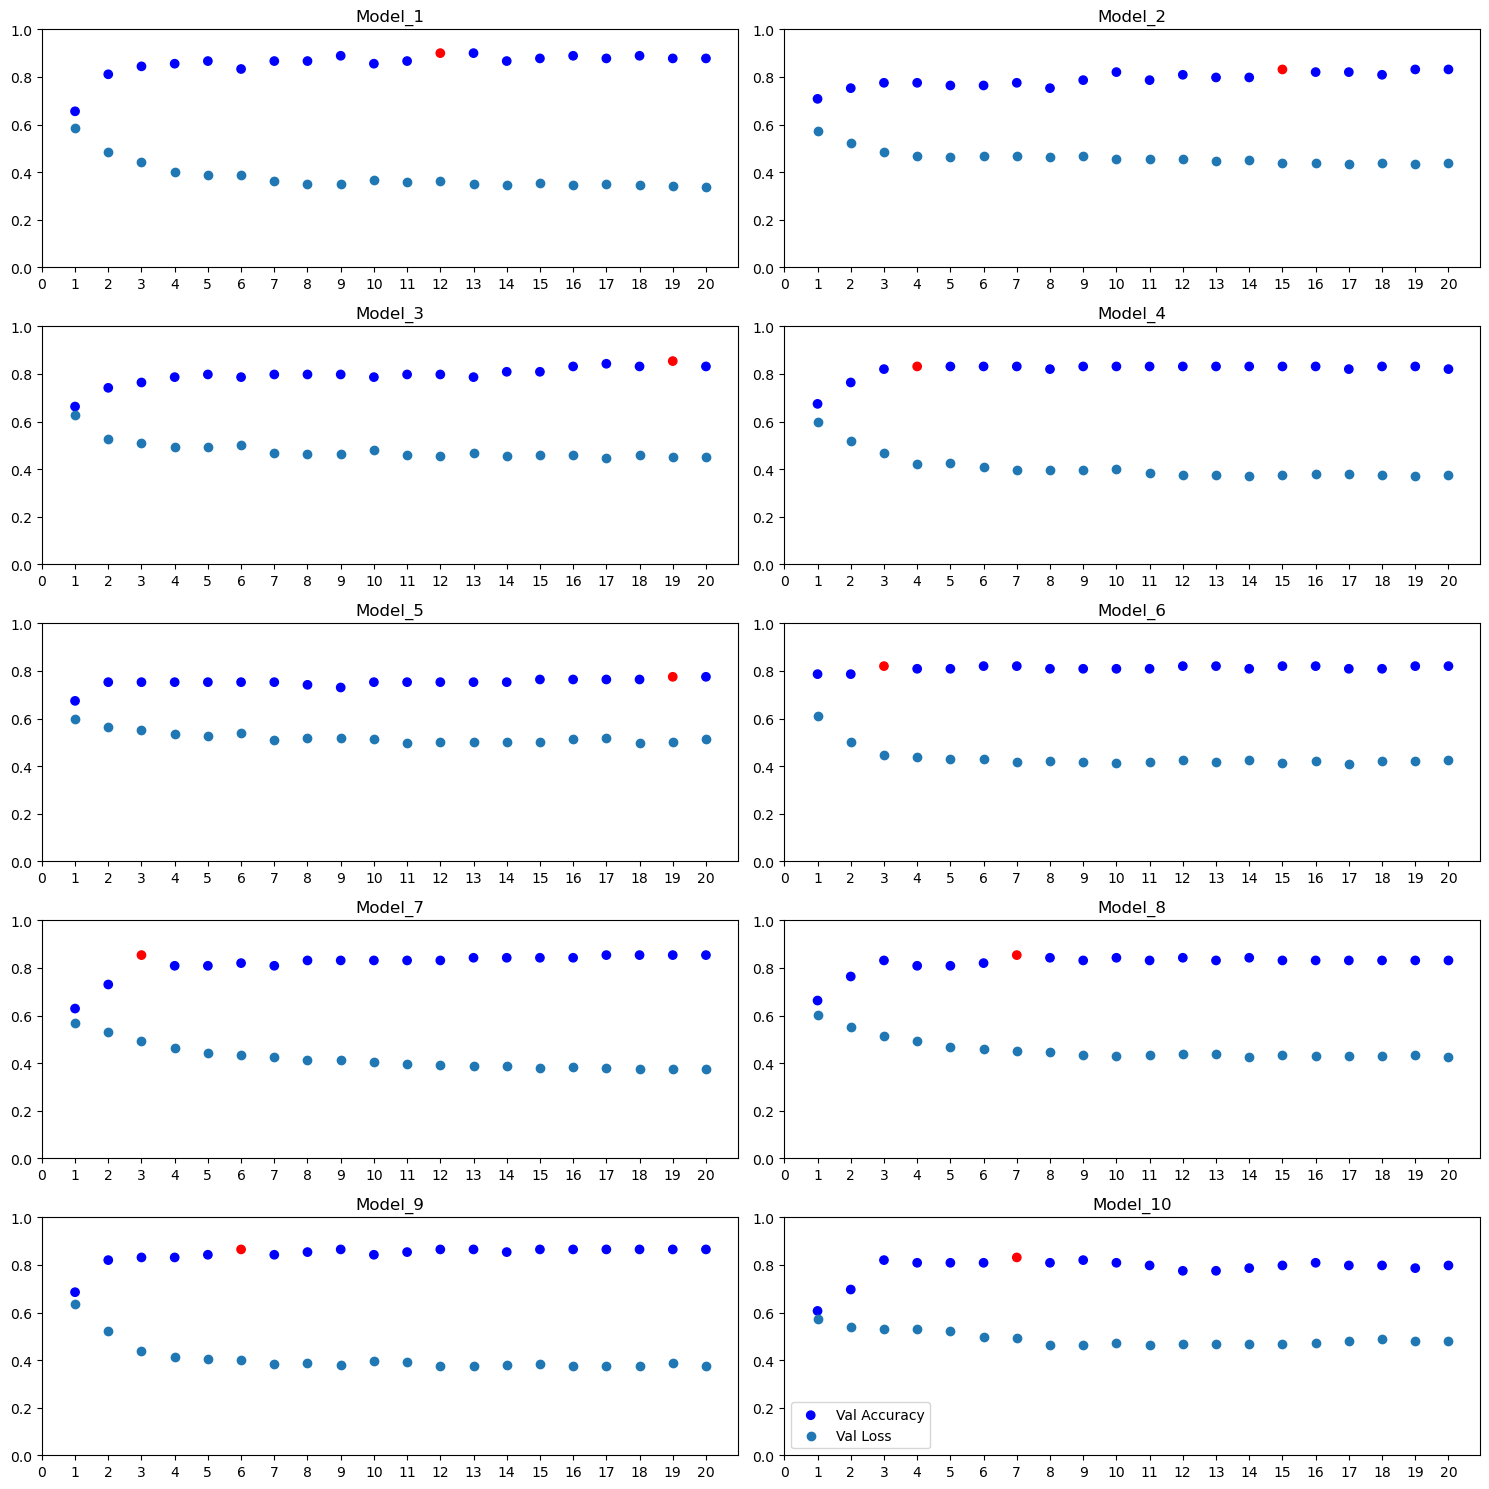

average last_acc: 0.8304743885993957


In [75]:
fig, axes = plt.subplots(kfolds//2, 2, figsize=(15, (kfolds//2)*3))

accuracies = list()

for i, (name, hist) in enumerate(histories.items()):
    # plotting data
    val_accs = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    epochs = np.arange(1, nepochs+1)
    
    # Get the exact axes
    ax = axes[i//2][i%2]
    
    # Info to highlight the best epoch
    max_acc = max(val_accs)
    best_epoch = val_accs.index(max_acc)
    colors = ['b' for i in range(len(val_accs))]
    colors[best_epoch] = 'r'
    accuracies.append(val_accs[-1])
    
    # Plot the graph
    ax.scatter(epochs, val_accs, c = colors, label="Val Accuracy")
    ax.scatter(epochs, val_loss, label="Val Loss")
    ax.set_title(name)
    ax.set_xticks(np.arange(0, nepochs+1,1))
    ax.set_xticklabels(np.arange(0, nepochs + 1,1))
    ax.set_ylim(0,1)
    
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

print(f"average last_acc: {sum(accuracies)/len(accuracies)}")

# Building the Final Model

So it looks like our model architecture is getting ~83% accuracy.  Let's use that architecture, trained on the entire dataset, as our final version.

In [76]:
from sklearn.model_selection import StratifiedKFold

# Training Parameters
nepochs = 20

# Setup new Data transformer
transformer = make_transformer()

# Get train/test data and transform it (also fitting the transformer)
x_train = transformer.fit_transform(clean_data)

y_train = clean_data.loc[:, "Survived"].to_numpy()

# Make the new model
model = create_model(f"Final_Model")

# Train and store history
hist = model.fit(x_train, y_train, batch_size=10, epochs=nepochs, verbose=0)

In [85]:
# Creating our final predictions
test_data = pd.read_csv("test.csv")

test_data["Sex"] = test_data["Sex"].replace({"male":0, "female":1})
test_data["Embarked"] = test_data["Embarked"].replace({"C":0, "Q":1, "S":2, np.NaN:3})
test_data.head()

test_data = transformer.transform(test_data)
predictions = model.predict(test_data)

In [92]:
test_data = pd.read_csv("test.csv")
test_data.iloc[1]

PassengerId                                 893
Pclass                                        3
Name           Wilkes, Mrs. James (Ellen Needs)
Sex                                      female
Age                                        47.0
SibSp                                         1
Parch                                         0
Ticket                                   363272
Fare                                        7.0
Cabin                                       NaN
Embarked                                      S
Name: 1, dtype: object

In [90]:
predictions

array([[0.06351143],
       [0.29368573],
       [0.02119198],
       [0.10939032],
       [0.3552124 ],
       [0.167117  ],
       [0.70242846],
       [0.13879073],
       [0.57179487],
       [0.08405918],
       [0.10642722],
       [0.2830267 ],
       [0.9563505 ],
       [0.04103687],
       [0.9394956 ],
       [0.9324049 ],
       [0.06070456],
       [0.2295135 ],
       [0.33746424],
       [0.4285829 ],
       [0.2615592 ],
       [0.32778627],
       [0.94777846],
       [0.67348933],
       [0.9139063 ],
       [0.06561768],
       [0.9629945 ],
       [0.2136153 ],
       [0.32066554],
       [0.15654612],
       [0.05992201],
       [0.11363021],
       [0.3114093 ],
       [0.32849088],
       [0.4447835 ],
       [0.256487  ],
       [0.4024624 ],
       [0.4434901 ],
       [0.11199778],
       [0.21164748],
       [0.12913191],
       [0.35177806],
       [0.09954676],
       [0.9128289 ],
       [0.93372333],
       [0.10990211],
       [0.24732524],
       [0.077

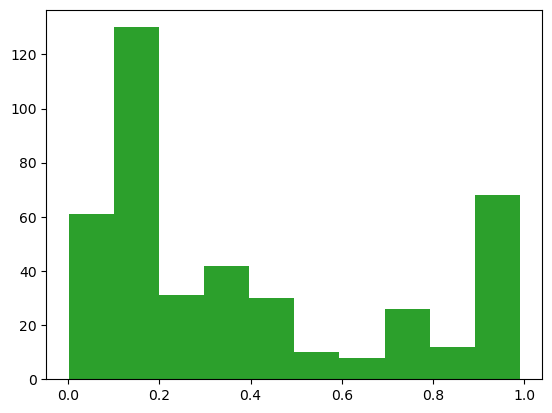

In [96]:
plt.hist(predictions)
plt.show()

In [103]:
binary_pred = [0 if pred < .50 else 1 for pred in predictions]

In [104]:
sum(binary_pred)/len(binary_pred)

0.2966507177033493

In [115]:
pred_df = pd.read_csv("test.csv")

pred_df["Survived"] = binary_pred
pred_df = pred_df.loc[:, ["PassengerId", "Survived"]]
pred_df.to_csv("predictions", index=False)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S,0
11,903,1,"Jones, Mr. Charles Cresson",male,46.0,0,0,694,26.0000,NaN,S,0
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,S,1
13,905,2,"Howard, Mr. Benjamin",male,63.0,1,0,24065,26.0000,NaN,S,0
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S,1
